In [20]:
import gensim
import spacy
import numpy as np
from pathlib import Path
from itertools import chain, islice
from cytoolz import concat
from time import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json

In [2]:
nlp = spacy.load('en', disable=["ner", "textcat"])

In [3]:
filename = "SMSSpamCollection.txt"

In [4]:
def preprocess(line):
    text = line.split("\t")[-1].strip()
    return text

def normalize_token(token):
    if token.lemma_ != "-PRON-":
        return token.lemma_
    return token.lower_

def construct_token(token):
    return normalize_token(token) + "_" + token.pos_

def add_boundaries(sentence):
    tokens = ["<S>"]
    tokens.extend([construct_token(token) for token in sentence])
    tokens.append("</S>")
    return tokens

def get_sentences(doc):
    return [add_boundaries(sent) for sent in doc.sents]

In [133]:
class Reader(object):
    
    def __init__(self, filename):
        self.filename = filename
        self.prepared_filename = "prepared_" + self.filename
        self._vocabulary = False
    
    def get_data(self):
        with open(self.filename) as f_in, open(self.prepared_filename, "w+") as f_out:
            texts = (preprocess(line) for line in f_in)
            docs = nlp.pipe(texts, disable=["ner", "textcat"])#, batch_size=500, n_threads=4)
            sents = concat(get_sentences(doc) for doc in docs )
            for sent in sents:
                f_out.write(json.dumps(sent)+"\n")
                yield sent
        self._vocabulary = True
    
    def get_prepared_data(self):
        with open(self.prepared_filename) as f:
            for k,line in enumerate(f):
                sent = json.loads(line.strip())
                yield sent
        
    def __iter__(self):
        if self._vocabulary:
            return self.get_prepared_data()
        else:
            return self.get_data()

In [134]:
t0 = time()
data = Reader(filename)
model1 = gensim.models.Word2Vec(data, size=10, window=3, min_count=1, iter=20, sg=0, 
                                negative=10, workers=8, seed=5, compute_loss=True)
print(f"Spent: {time()-t0:.3f}")

Spent: 25.063


In [135]:
model1.get_latest_training_loss()

1025800.625

In [156]:
t0 = time()
with open(filename) as file:
    texts = (preprocess(line) for line in file)
    docs = nlp.pipe(texts, disable=["ner", "textcat"])#, batch_size=500, n_threads=4)
    sents = list(concat(get_sentences(doc) for doc in docs))
    model = gensim.models.Word2Vec(sents, size=10, window=3, min_count=1, iter=10, sg=0, 
                                    negative=5, workers=8, seed=5, compute_loss=True)
print(f"Spent: {time()-t0:.3f}")

Spent: 20.793


In [157]:
model.wv.vectors

array([[ 0.21341272,  0.5213052 , -2.0154915 , ..., -1.4942038 ,
         1.8003622 , -0.19996892],
       [-2.4826162 ,  1.364773  , -2.3824754 , ..., -2.033111  ,
         1.4778873 ,  1.2724034 ],
       [ 0.23243481,  1.8228145 , -0.7413015 , ..., -1.6479363 ,
         2.3170695 , -1.3159939 ],
       ...,
       [-0.09825307,  0.0210263 , -0.02673768, ..., -0.09607616,
         0.1276138 , -0.01351917],
       [-0.00576536, -0.03284713,  0.0160141 , ..., -0.06041109,
         0.03704417,  0.00561708],
       [ 0.03998662,  0.00454564, -0.00780358, ..., -0.04418023,
         0.08800822, -0.02005707]], dtype=float32)

In [158]:
model.get_latest_training_loss()

368399.375

In [119]:
model.save("w2v.model")

In [54]:
print("The vocabulary contains {} tokens.".format(len(model.wv.vocab)))

The vocabulary contains 10707 tokens.


In [148]:
sample_words = [word for word in model.wv.vocab if "%" in word]
sample_words

['%_NOUN']

In [149]:
model.wv.most_similar(positive=[#"sale_NOUN", "sale_PROPN", 
                                #"free_ADJ", "free_PROPN", "free_ADV", "free_VERB",
                               "discount_NOUN"
                               # "£_SYM",
                                #"%_NOUN"
                                ], topn=20)

[('worth_NOUN', 0.9604555368423462),
 ('genuine_ADJ', 0.9459621906280518),
 ('video_PROPN', 0.942803680896759),
 ('special_PROPN', 0.9298160076141357),
 ('lotr_PROPN', 0.9297105669975281),
 ('supply_NOUN', 0.9219450950622559),
 ('music_PROPN', 0.9212424159049988),
 ('puzzle_NOUN', 0.917346179485321),
 ('pert_NOUN', 0.9109663367271423),
 ('xma_NOUN', 0.9063178300857544),
 ('homeowner_NOUN', 0.9057468771934509),
 ('artist_NOUN', 0.9018898606300354),
 ('subscription_PROPN', 0.8977100849151611),
 ('cd_PROPN', 0.897445797920227),
 ('tenant_NOUN', 0.8938726782798767),
 ('pdate_now_ADV', 0.8925958871841431),
 ('logo_NOUN', 0.8925094604492188),
 ('house_PROPN', 0.8894658088684082),
 ('mystery_NOUN', 0.8891306519508362),
 ('world_PROPN', 0.888996958732605)]

In [150]:
model.wv.similarity("cash_NOUN", "free_ADV")

0.5119567440379406

In [151]:
model.wv.similarity("free_ADV", "woman_NOUN")

0.0765639661157946

In [90]:
model.wv.doesnt_match(["lunch_NOUN", "discount_NOUN", "free_ADV"])

'lunch_NOUN'

/home/karimlulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


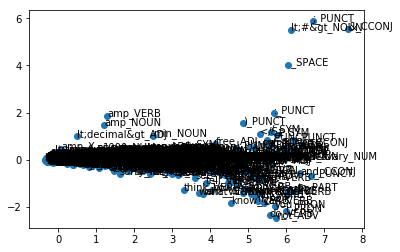

In [159]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [155]:
#%matplotlib inline
# https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(title, model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16))
    plt.title(title)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot("vectors", model)